In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import logging

module_path = os.path.abspath(os.path.join("../../.."))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from pathlib import Path

import torch
import torch.utils.data
from torchvision import transforms, datasets
import numpy as np
import matplotlib.pyplot as plt

import pvi
from pvi.models import ClassificationBNNLocalRepam
from pvi.clients import Client
from pvi.servers import SequentialServer
from pvi.distributions import MeanFieldGaussianDistribution, MeanFieldGaussianFactor
from pvi.utils.training_utils import EarlyStopping

In [2]:
data_dir = Path("/Users/terjemildner/Desktop/data")
cache_dir = Path("/Users/terjemildner/Desktop/PVI-main/experiments/femnist")

## Define various functions for splitting data and recording performance metrics.

In [3]:
# Data splitting functions.
def homogeneous_split(data, num_clients=100, seed=42):
    # Set numpy's random seed.
    np.random.seed(seed)
    
    perm = np.random.permutation(len(data["x"]))
    client_data = []
    for i in range(num_clients):
        client_idx = perm[i::num_clients]
        client_data.append({"x": data["x"][client_idx], "y": data["y"][client_idx]})
    
    return client_data


# Performance metric function. Why is the batch size 512 when the split gives 600? => Mini batches?
def performance_metrics(client, data, batch_size=512):
    dataset = torch.utils.data.TensorDataset(data["x"], data["y"])
    loader = torch.utils.data.DataLoader(dataset, batch_size=512, shuffle=False)
    
    device = client.config["device"]
    
    if device == "cuda":
        loader.pin_memory = True
        
    preds, mlls = [], []
    for (x_batch, y_batch) in loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        pp = client.model_predict(x_batch)
        preds.append(pp.component_distribution.probs.mean(1).cpu())
        mlls.append(pp.log_prob(y_batch).cpu())
        
    mll = torch.cat(mlls).mean()
    preds = torch.cat(preds)
    acc = sum(torch.argmax(preds, dim=-1) == loader.dataset.tensors[1]) / len(
        loader.dataset.tensors[1]
    )
    
    return {"mll": mll, "acc": acc}

## Data preprocessing

In [4]:
transform_train = transforms.Compose([transforms.ToTensor()])
transform_test = transforms.Compose([transforms.ToTensor()])

train_set = datasets.MNIST(root=data_dir, train=True, download=True, transform=transform_train)
test_set = datasets.MNIST(root=data_dir, train=False, download=True, transform=transform_test)

train_data = {
    "x": ((train_set.data - 0) / 255).reshape(-1, 28 * 28),
    "y": train_set.targets,
}

test_data = {
    "x": ((test_set.data - 0) / 255).reshape(-1, 28 * 28),
    "y": test_set.targets,
}

In [5]:
# Get client splits.
client_data = homogeneous_split(train_data, 1, seed=42)


## Define configuration for server and clients

In [6]:
model_config = {
    "input_dim": 784,
    "latent_dim": 200,
    "output_dim": 10,
    "num_layers": 1,
    "num_predictive_samples": 100,
    "prior_var": 1.0,
}

client_config = {
    "damping_factor": 1.0,
    "optimiser": "Adam",
    "optimiser_params": {"lr": 2e-3},
    "sigma_optimiser_params": {"lr": 2e-3},
    "early_stopping": EarlyStopping(20, score_name="elbo", stash_model=True),
    "performance_metrics": performance_metrics,
    "batch_size": 1024,
    "epochs": 2,
    "print_epochs": np.inf,
    "num_elbo_samples": 10,
    "valid_factors": False,
    "device": "cpu",
    "init_var": 1e-3,
    "verbose": True,
}

server_config = {
    **client_config,
    #100
    "max_iterations": 250,
}

## Set up model etc.

In [7]:
device = server_config["device"]

model = ClassificationBNNLocalRepam(config=model_config)

# Initial parameters.
init_q_std_params = {
    "loc": torch.zeros(size=(model.num_parameters,)).to(device).uniform_(-0.1, 0.1),
    "scale": torch.ones(size=(model.num_parameters,)).to(device) 
    * client_config["init_var"] ** 0.5,
}

prior_std_params = {
    "loc": torch.zeros(size=(model.num_parameters,)).to(device),
    "scale": model_config["prior_var"] ** 0.5 
    * torch.ones(size=(model.num_parameters,)).to(device),
}

init_factor_nat_params = {
    "np1": torch.zeros(model.num_parameters).to(device),
    "np2": torch.zeros(model.num_parameters).to(device),
}

p = MeanFieldGaussianDistribution(
    std_params=prior_std_params, is_trainable=False
)
init_q = MeanFieldGaussianDistribution(
    std_params=init_q_std_params, is_trainable=False
)

clients = []
size_training = 0
for i in range(1):
    data_i = client_data[i]
    size_training += len(data_i["x"])
    t_i = MeanFieldGaussianFactor(nat_params=init_factor_nat_params)
    clients.append(
        Client(
            data=data_i,
            model=model,
            t=t_i,
            config=client_config,
            val_data=test_data
        )
    )    
server = SequentialServer(model=model, p=p, clients=clients, config=server_config, init_q=init_q, data=train_data, val_data=test_data)

## Run PVI! 1 Hidden Layer

In [23]:
i = 0
while not server.should_stop():
    server.tick()

    # Obtain performance metrics.
    metrics = server.log["performance_metrics"][-1]
    print("Iterations: {}.".format(i))
    print("Time taken: {:.3f}.".format(metrics["time"]))
    print(
      "Test mll: {:.3f}. Test acc: {:.3f}.".format(
          metrics["val_mll"], metrics["val_acc"]
      )
    )
    print(
      "Train mll: {:.3f}. Train acc: {:.3f}.\n".format(
          metrics["train_mll"], metrics["train_acc"]
      )
    )
    i += 1

0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 0.
Time taken: 5.890.
Test mll: -0.193. Test acc: 0.946.
Train mll: -0.194. Train acc: 0.947.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 1.
Time taken: 11.777.
Test mll: -0.116. Test acc: 0.967.
Train mll: -0.106. Train acc: 0.971.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 2.
Time taken: 17.765.
Test mll: -0.089. Test acc: 0.974.
Train mll: -0.070. Train acc: 0.981.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 3.
Time taken: 23.764.
Test mll: -0.073. Test acc: 0.977.
Train mll: -0.050. Train acc: 0.987.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 4.
Time taken: 29.776.
Test mll: -0.069. Test acc: 0.979.
Train mll: -0.040. Train acc: 0.991.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 5.
Time taken: 35.835.
Test mll: -0.062. Test acc: 0.981.
Train mll: -0.032. Train acc: 0.994.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 6.
Time taken: 41.728.
Test mll: -0.059. Test acc: 0.981.
Train mll: -0.027. Train acc: 0.995.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 7.
Time taken: 47.810.
Test mll: -0.057. Test acc: 0.982.
Train mll: -0.024. Train acc: 0.996.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 8.
Time taken: 53.884.
Test mll: -0.058. Test acc: 0.982.
Train mll: -0.024. Train acc: 0.997.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 9.
Time taken: 59.832.
Test mll: -0.056. Test acc: 0.982.
Train mll: -0.022. Train acc: 0.997.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 10.
Time taken: 65.772.
Test mll: -0.058. Test acc: 0.983.
Train mll: -0.023. Train acc: 0.998.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 11.
Time taken: 71.771.
Test mll: -0.055. Test acc: 0.983.
Train mll: -0.024. Train acc: 0.998.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 12.
Time taken: 77.807.
Test mll: -0.056. Test acc: 0.984.
Train mll: -0.025. Train acc: 0.998.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 13.
Time taken: 83.908.
Test mll: -0.059. Test acc: 0.984.
Train mll: -0.027. Train acc: 0.997.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 14.
Time taken: 89.922.
Test mll: -0.059. Test acc: 0.984.
Train mll: -0.028. Train acc: 0.997.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 15.
Time taken: 95.932.
Test mll: -0.060. Test acc: 0.984.
Train mll: -0.032. Train acc: 0.997.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 16.
Time taken: 101.994.
Test mll: -0.062. Test acc: 0.984.
Train mll: -0.034. Train acc: 0.996.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 17.
Time taken: 107.969.
Test mll: -0.062. Test acc: 0.984.
Train mll: -0.037. Train acc: 0.996.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 18.
Time taken: 113.990.
Test mll: -0.065. Test acc: 0.984.
Train mll: -0.039. Train acc: 0.995.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 19.
Time taken: 119.963.
Test mll: -0.064. Test acc: 0.985.
Train mll: -0.042. Train acc: 0.995.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 20.
Time taken: 125.992.
Test mll: -0.068. Test acc: 0.983.
Train mll: -0.045. Train acc: 0.994.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 21.
Time taken: 132.013.
Test mll: -0.069. Test acc: 0.983.
Train mll: -0.047. Train acc: 0.994.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 22.
Time taken: 137.908.
Test mll: -0.071. Test acc: 0.983.
Train mll: -0.050. Train acc: 0.993.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 23.
Time taken: 143.977.
Test mll: -0.072. Test acc: 0.983.
Train mll: -0.053. Train acc: 0.992.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 24.
Time taken: 149.985.
Test mll: -0.075. Test acc: 0.982.
Train mll: -0.055. Train acc: 0.991.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 25.
Time taken: 155.918.
Test mll: -0.075. Test acc: 0.983.
Train mll: -0.058. Train acc: 0.991.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 26.
Time taken: 161.856.
Test mll: -0.078. Test acc: 0.982.
Train mll: -0.059. Train acc: 0.990.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 27.
Time taken: 167.902.
Test mll: -0.078. Test acc: 0.982.
Train mll: -0.061. Train acc: 0.990.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 28.
Time taken: 173.810.
Test mll: -0.079. Test acc: 0.981.
Train mll: -0.063. Train acc: 0.989.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 29.
Time taken: 179.456.
Test mll: -0.079. Test acc: 0.981.
Train mll: -0.064. Train acc: 0.989.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 30.
Time taken: 185.402.
Test mll: -0.080. Test acc: 0.980.
Train mll: -0.065. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 31.
Time taken: 191.344.
Test mll: -0.082. Test acc: 0.980.
Train mll: -0.065. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 32.
Time taken: 197.257.
Test mll: -0.081. Test acc: 0.980.
Train mll: -0.065. Train acc: 0.987.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 33.
Time taken: 203.228.
Test mll: -0.080. Test acc: 0.980.
Train mll: -0.066. Train acc: 0.987.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 34.
Time taken: 209.152.
Test mll: -0.081. Test acc: 0.980.
Train mll: -0.066. Train acc: 0.987.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 35.
Time taken: 215.027.
Test mll: -0.081. Test acc: 0.980.
Train mll: -0.066. Train acc: 0.987.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 36.
Time taken: 221.261.
Test mll: -0.080. Test acc: 0.980.
Train mll: -0.066. Train acc: 0.987.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 37.
Time taken: 227.028.
Test mll: -0.081. Test acc: 0.979.
Train mll: -0.066. Train acc: 0.986.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 38.
Time taken: 232.906.
Test mll: -0.081. Test acc: 0.979.
Train mll: -0.066. Train acc: 0.986.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 39.
Time taken: 238.975.
Test mll: -0.081. Test acc: 0.979.
Train mll: -0.066. Train acc: 0.986.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 40.
Time taken: 244.855.
Test mll: -0.082. Test acc: 0.979.
Train mll: -0.067. Train acc: 0.986.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 41.
Time taken: 250.707.
Test mll: -0.080. Test acc: 0.980.
Train mll: -0.067. Train acc: 0.986.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 42.
Time taken: 256.593.
Test mll: -0.081. Test acc: 0.980.
Train mll: -0.067. Train acc: 0.986.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 43.
Time taken: 262.417.
Test mll: -0.080. Test acc: 0.979.
Train mll: -0.066. Train acc: 0.986.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 44.
Time taken: 268.234.
Test mll: -0.080. Test acc: 0.980.
Train mll: -0.066. Train acc: 0.987.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 45.
Time taken: 274.229.
Test mll: -0.079. Test acc: 0.979.
Train mll: -0.066. Train acc: 0.986.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 46.
Time taken: 280.239.
Test mll: -0.080. Test acc: 0.979.
Train mll: -0.066. Train acc: 0.986.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 47.
Time taken: 286.265.
Test mll: -0.080. Test acc: 0.980.
Train mll: -0.066. Train acc: 0.986.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 48.
Time taken: 292.297.
Test mll: -0.080. Test acc: 0.979.
Train mll: -0.066. Train acc: 0.987.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 49.
Time taken: 298.277.
Test mll: -0.078. Test acc: 0.979.
Train mll: -0.065. Train acc: 0.986.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 50.
Time taken: 304.413.
Test mll: -0.079. Test acc: 0.980.
Train mll: -0.065. Train acc: 0.986.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 51.
Time taken: 310.341.
Test mll: -0.079. Test acc: 0.979.
Train mll: -0.066. Train acc: 0.986.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 52.
Time taken: 316.144.
Test mll: -0.079. Test acc: 0.980.
Train mll: -0.065. Train acc: 0.986.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 53.
Time taken: 322.003.
Test mll: -0.080. Test acc: 0.979.
Train mll: -0.066. Train acc: 0.986.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 54.
Time taken: 327.976.
Test mll: -0.079. Test acc: 0.979.
Train mll: -0.065. Train acc: 0.987.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 55.
Time taken: 333.822.
Test mll: -0.079. Test acc: 0.979.
Train mll: -0.065. Train acc: 0.986.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 56.
Time taken: 339.563.
Test mll: -0.079. Test acc: 0.979.
Train mll: -0.064. Train acc: 0.987.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 57.
Time taken: 345.539.
Test mll: -0.078. Test acc: 0.979.
Train mll: -0.064. Train acc: 0.986.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 58.
Time taken: 351.515.
Test mll: -0.077. Test acc: 0.980.
Train mll: -0.064. Train acc: 0.986.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 59.
Time taken: 357.404.
Test mll: -0.079. Test acc: 0.979.
Train mll: -0.064. Train acc: 0.986.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 60.
Time taken: 363.344.
Test mll: -0.078. Test acc: 0.980.
Train mll: -0.064. Train acc: 0.986.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 61.
Time taken: 369.170.
Test mll: -0.077. Test acc: 0.980.
Train mll: -0.064. Train acc: 0.986.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 62.
Time taken: 375.071.
Test mll: -0.078. Test acc: 0.979.
Train mll: -0.064. Train acc: 0.986.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 63.
Time taken: 381.047.
Test mll: -0.078. Test acc: 0.979.
Train mll: -0.064. Train acc: 0.986.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 64.
Time taken: 386.969.
Test mll: -0.078. Test acc: 0.979.
Train mll: -0.064. Train acc: 0.987.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 65.
Time taken: 392.903.
Test mll: -0.077. Test acc: 0.979.
Train mll: -0.063. Train acc: 0.987.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 66.
Time taken: 398.782.
Test mll: -0.078. Test acc: 0.979.
Train mll: -0.063. Train acc: 0.986.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 67.
Time taken: 404.770.
Test mll: -0.077. Test acc: 0.979.
Train mll: -0.064. Train acc: 0.987.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 68.
Time taken: 410.634.
Test mll: -0.078. Test acc: 0.979.
Train mll: -0.063. Train acc: 0.987.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 69.
Time taken: 416.718.
Test mll: -0.077. Test acc: 0.979.
Train mll: -0.063. Train acc: 0.987.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 70.
Time taken: 422.612.
Test mll: -0.076. Test acc: 0.979.
Train mll: -0.063. Train acc: 0.987.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 71.
Time taken: 428.411.
Test mll: -0.077. Test acc: 0.981.
Train mll: -0.063. Train acc: 0.987.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 72.
Time taken: 434.272.
Test mll: -0.077. Test acc: 0.979.
Train mll: -0.063. Train acc: 0.986.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 73.
Time taken: 440.113.
Test mll: -0.076. Test acc: 0.980.
Train mll: -0.063. Train acc: 0.987.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 74.
Time taken: 446.019.
Test mll: -0.076. Test acc: 0.979.
Train mll: -0.062. Train acc: 0.987.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 75.
Time taken: 451.755.
Test mll: -0.077. Test acc: 0.979.
Train mll: -0.062. Train acc: 0.986.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 76.
Time taken: 457.839.
Test mll: -0.076. Test acc: 0.980.
Train mll: -0.063. Train acc: 0.987.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 77.
Time taken: 463.841.
Test mll: -0.076. Test acc: 0.980.
Train mll: -0.062. Train acc: 0.987.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 78.
Time taken: 469.816.
Test mll: -0.076. Test acc: 0.979.
Train mll: -0.062. Train acc: 0.987.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 79.
Time taken: 475.863.
Test mll: -0.077. Test acc: 0.979.
Train mll: -0.062. Train acc: 0.987.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 80.
Time taken: 481.948.
Test mll: -0.077. Test acc: 0.980.
Train mll: -0.062. Train acc: 0.987.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 81.
Time taken: 488.044.
Test mll: -0.077. Test acc: 0.980.
Train mll: -0.062. Train acc: 0.987.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 82.
Time taken: 493.946.
Test mll: -0.076. Test acc: 0.980.
Train mll: -0.062. Train acc: 0.987.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 83.
Time taken: 499.914.
Test mll: -0.077. Test acc: 0.979.
Train mll: -0.062. Train acc: 0.987.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 84.
Time taken: 505.868.
Test mll: -0.076. Test acc: 0.980.
Train mll: -0.062. Train acc: 0.987.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 85.
Time taken: 511.731.
Test mll: -0.077. Test acc: 0.979.
Train mll: -0.062. Train acc: 0.987.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 86.
Time taken: 517.591.
Test mll: -0.076. Test acc: 0.979.
Train mll: -0.061. Train acc: 0.987.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 87.
Time taken: 523.513.
Test mll: -0.077. Test acc: 0.980.
Train mll: -0.062. Train acc: 0.987.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 88.
Time taken: 529.391.
Test mll: -0.077. Test acc: 0.979.
Train mll: -0.061. Train acc: 0.987.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 89.
Time taken: 535.311.
Test mll: -0.075. Test acc: 0.980.
Train mll: -0.061. Train acc: 0.987.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 90.
Time taken: 541.220.
Test mll: -0.076. Test acc: 0.979.
Train mll: -0.061. Train acc: 0.987.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 91.
Time taken: 547.069.
Test mll: -0.077. Test acc: 0.979.
Train mll: -0.061. Train acc: 0.987.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 92.
Time taken: 552.971.
Test mll: -0.076. Test acc: 0.979.
Train mll: -0.061. Train acc: 0.987.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 93.
Time taken: 558.912.
Test mll: -0.075. Test acc: 0.979.
Train mll: -0.061. Train acc: 0.987.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 94.
Time taken: 564.818.
Test mll: -0.075. Test acc: 0.979.
Train mll: -0.060. Train acc: 0.987.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 95.
Time taken: 570.755.
Test mll: -0.075. Test acc: 0.979.
Train mll: -0.061. Train acc: 0.987.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 96.
Time taken: 576.718.
Test mll: -0.076. Test acc: 0.979.
Train mll: -0.061. Train acc: 0.987.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 97.
Time taken: 582.711.
Test mll: -0.075. Test acc: 0.979.
Train mll: -0.061. Train acc: 0.987.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 98.
Time taken: 588.588.
Test mll: -0.076. Test acc: 0.980.
Train mll: -0.061. Train acc: 0.987.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 99.
Time taken: 594.542.
Test mll: -0.076. Test acc: 0.980.
Train mll: -0.061. Train acc: 0.987.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 100.
Time taken: 600.349.
Test mll: -0.076. Test acc: 0.979.
Train mll: -0.061. Train acc: 0.987.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 101.
Time taken: 606.254.
Test mll: -0.075. Test acc: 0.979.
Train mll: -0.060. Train acc: 0.987.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 102.
Time taken: 612.153.
Test mll: -0.075. Test acc: 0.979.
Train mll: -0.060. Train acc: 0.987.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 103.
Time taken: 618.085.
Test mll: -0.076. Test acc: 0.979.
Train mll: -0.060. Train acc: 0.987.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 104.
Time taken: 624.028.
Test mll: -0.077. Test acc: 0.979.
Train mll: -0.060. Train acc: 0.987.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 105.
Time taken: 629.989.
Test mll: -0.074. Test acc: 0.979.
Train mll: -0.060. Train acc: 0.987.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 106.
Time taken: 635.992.
Test mll: -0.075. Test acc: 0.979.
Train mll: -0.060. Train acc: 0.987.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 107.
Time taken: 642.099.
Test mll: -0.075. Test acc: 0.979.
Train mll: -0.060. Train acc: 0.987.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 108.
Time taken: 648.234.
Test mll: -0.076. Test acc: 0.979.
Train mll: -0.060. Train acc: 0.987.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 109.
Time taken: 654.430.
Test mll: -0.075. Test acc: 0.979.
Train mll: -0.060. Train acc: 0.987.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 110.
Time taken: 660.440.
Test mll: -0.075. Test acc: 0.980.
Train mll: -0.060. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 111.
Time taken: 666.396.
Test mll: -0.075. Test acc: 0.980.
Train mll: -0.060. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 112.
Time taken: 672.308.
Test mll: -0.076. Test acc: 0.979.
Train mll: -0.060. Train acc: 0.987.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 113.
Time taken: 678.245.
Test mll: -0.075. Test acc: 0.979.
Train mll: -0.059. Train acc: 0.987.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 114.
Time taken: 684.112.
Test mll: -0.075. Test acc: 0.980.
Train mll: -0.059. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 115.
Time taken: 690.084.
Test mll: -0.075. Test acc: 0.979.
Train mll: -0.059. Train acc: 0.987.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 116.
Time taken: 695.973.
Test mll: -0.074. Test acc: 0.980.
Train mll: -0.059. Train acc: 0.987.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 117.
Time taken: 701.953.
Test mll: -0.075. Test acc: 0.980.
Train mll: -0.059. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 118.
Time taken: 707.894.
Test mll: -0.076. Test acc: 0.979.
Train mll: -0.059. Train acc: 0.987.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 119.
Time taken: 713.787.
Test mll: -0.074. Test acc: 0.979.
Train mll: -0.060. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 120.
Time taken: 719.707.
Test mll: -0.075. Test acc: 0.979.
Train mll: -0.059. Train acc: 0.987.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 121.
Time taken: 725.677.
Test mll: -0.074. Test acc: 0.979.
Train mll: -0.059. Train acc: 0.987.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 122.
Time taken: 731.639.
Test mll: -0.074. Test acc: 0.979.
Train mll: -0.059. Train acc: 0.987.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 123.
Time taken: 737.486.
Test mll: -0.074. Test acc: 0.979.
Train mll: -0.059. Train acc: 0.987.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 124.
Time taken: 743.408.
Test mll: -0.075. Test acc: 0.979.
Train mll: -0.059. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 125.
Time taken: 749.177.
Test mll: -0.075. Test acc: 0.979.
Train mll: -0.059. Train acc: 0.987.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 126.
Time taken: 754.989.
Test mll: -0.075. Test acc: 0.979.
Train mll: -0.059. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 127.
Time taken: 760.858.
Test mll: -0.074. Test acc: 0.979.
Train mll: -0.058. Train acc: 0.987.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 128.
Time taken: 766.535.
Test mll: -0.075. Test acc: 0.979.
Train mll: -0.058. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 129.
Time taken: 772.337.
Test mll: -0.074. Test acc: 0.979.
Train mll: -0.059. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 130.
Time taken: 778.100.
Test mll: -0.075. Test acc: 0.980.
Train mll: -0.059. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 131.
Time taken: 783.950.
Test mll: -0.075. Test acc: 0.980.
Train mll: -0.059. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 132.
Time taken: 789.740.
Test mll: -0.075. Test acc: 0.980.
Train mll: -0.058. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 133.
Time taken: 795.491.
Test mll: -0.075. Test acc: 0.978.
Train mll: -0.058. Train acc: 0.987.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 134.
Time taken: 801.332.
Test mll: -0.075. Test acc: 0.979.
Train mll: -0.058. Train acc: 0.987.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 135.
Time taken: 807.204.
Test mll: -0.075. Test acc: 0.979.
Train mll: -0.058. Train acc: 0.987.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 136.
Time taken: 812.959.
Test mll: -0.073. Test acc: 0.980.
Train mll: -0.058. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 137.
Time taken: 818.798.
Test mll: -0.075. Test acc: 0.979.
Train mll: -0.058. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 138.
Time taken: 824.664.
Test mll: -0.074. Test acc: 0.979.
Train mll: -0.057. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 139.
Time taken: 830.470.
Test mll: -0.074. Test acc: 0.980.
Train mll: -0.058. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 140.
Time taken: 836.473.
Test mll: -0.075. Test acc: 0.979.
Train mll: -0.058. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 141.
Time taken: 842.431.
Test mll: -0.074. Test acc: 0.980.
Train mll: -0.058. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 142.
Time taken: 848.413.
Test mll: -0.074. Test acc: 0.979.
Train mll: -0.058. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 143.
Time taken: 854.382.
Test mll: -0.074. Test acc: 0.978.
Train mll: -0.058. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 144.
Time taken: 860.406.
Test mll: -0.074. Test acc: 0.980.
Train mll: -0.058. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 145.
Time taken: 866.328.
Test mll: -0.074. Test acc: 0.979.
Train mll: -0.058. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 146.
Time taken: 872.718.
Test mll: -0.073. Test acc: 0.979.
Train mll: -0.058. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 147.
Time taken: 878.419.
Test mll: -0.075. Test acc: 0.979.
Train mll: -0.058. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 148.
Time taken: 884.344.
Test mll: -0.075. Test acc: 0.979.
Train mll: -0.058. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 149.
Time taken: 890.256.
Test mll: -0.075. Test acc: 0.978.
Train mll: -0.058. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 150.
Time taken: 896.102.
Test mll: -0.075. Test acc: 0.979.
Train mll: -0.058. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 151.
Time taken: 902.006.
Test mll: -0.074. Test acc: 0.979.
Train mll: -0.057. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 152.
Time taken: 908.678.
Test mll: -0.074. Test acc: 0.979.
Train mll: -0.057. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 153.
Time taken: 916.088.
Test mll: -0.074. Test acc: 0.979.
Train mll: -0.058. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 154.
Time taken: 923.165.
Test mll: -0.073. Test acc: 0.979.
Train mll: -0.057. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 155.
Time taken: 929.976.
Test mll: -0.074. Test acc: 0.980.
Train mll: -0.057. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 156.
Time taken: 936.845.
Test mll: -0.074. Test acc: 0.979.
Train mll: -0.057. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 157.
Time taken: 944.086.
Test mll: -0.075. Test acc: 0.979.
Train mll: -0.058. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 158.
Time taken: 950.996.
Test mll: -0.073. Test acc: 0.979.
Train mll: -0.057. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 159.
Time taken: 957.743.
Test mll: -0.074. Test acc: 0.979.
Train mll: -0.057. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 160.
Time taken: 964.472.
Test mll: -0.074. Test acc: 0.979.
Train mll: -0.057. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 161.
Time taken: 970.949.
Test mll: -0.073. Test acc: 0.979.
Train mll: -0.057. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 162.
Time taken: 977.296.
Test mll: -0.074. Test acc: 0.979.
Train mll: -0.057. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 163.
Time taken: 983.682.
Test mll: -0.074. Test acc: 0.979.
Train mll: -0.057. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 164.
Time taken: 990.743.
Test mll: -0.074. Test acc: 0.979.
Train mll: -0.057. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 165.
Time taken: 1713.762.
Test mll: -0.074. Test acc: 0.979.
Train mll: -0.057. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 166.
Time taken: 1720.764.
Test mll: -0.074. Test acc: 0.979.
Train mll: -0.057. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 167.
Time taken: 1727.920.
Test mll: -0.074. Test acc: 0.979.
Train mll: -0.057. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 168.
Time taken: 1734.263.
Test mll: -0.073. Test acc: 0.980.
Train mll: -0.057. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 169.
Time taken: 1740.500.
Test mll: -0.074. Test acc: 0.980.
Train mll: -0.057. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 170.
Time taken: 1746.802.
Test mll: -0.074. Test acc: 0.979.
Train mll: -0.057. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 171.
Time taken: 1753.032.
Test mll: -0.073. Test acc: 0.980.
Train mll: -0.057. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 172.
Time taken: 1759.374.
Test mll: -0.074. Test acc: 0.980.
Train mll: -0.057. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 173.
Time taken: 1765.693.
Test mll: -0.073. Test acc: 0.980.
Train mll: -0.057. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 174.
Time taken: 1772.106.
Test mll: -0.074. Test acc: 0.979.
Train mll: -0.057. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 175.
Time taken: 1778.482.
Test mll: -0.073. Test acc: 0.979.
Train mll: -0.057. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 176.
Time taken: 1784.858.
Test mll: -0.075. Test acc: 0.979.
Train mll: -0.057. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 177.
Time taken: 1791.214.
Test mll: -0.073. Test acc: 0.979.
Train mll: -0.057. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 178.
Time taken: 1798.335.
Test mll: -0.073. Test acc: 0.979.
Train mll: -0.057. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 179.
Time taken: 1805.429.
Test mll: -0.074. Test acc: 0.979.
Train mll: -0.057. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 180.
Time taken: 1812.564.
Test mll: -0.074. Test acc: 0.979.
Train mll: -0.057. Train acc: 0.989.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 181.
Time taken: 1819.644.
Test mll: -0.074. Test acc: 0.979.
Train mll: -0.057. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 182.
Time taken: 1826.071.
Test mll: -0.074. Test acc: 0.980.
Train mll: -0.057. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 183.
Time taken: 1832.742.
Test mll: -0.073. Test acc: 0.980.
Train mll: -0.057. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 184.
Time taken: 1839.138.
Test mll: -0.073. Test acc: 0.979.
Train mll: -0.057. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 185.
Time taken: 1845.550.
Test mll: -0.075. Test acc: 0.979.
Train mll: -0.057. Train acc: 0.987.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 186.
Time taken: 1851.968.
Test mll: -0.074. Test acc: 0.979.
Train mll: -0.057. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 187.
Time taken: 1858.410.
Test mll: -0.074. Test acc: 0.979.
Train mll: -0.057. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 188.
Time taken: 1865.601.
Test mll: -0.074. Test acc: 0.979.
Train mll: -0.057. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 189.
Time taken: 1872.445.
Test mll: -0.073. Test acc: 0.979.
Train mll: -0.057. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 190.
Time taken: 1879.510.
Test mll: -0.073. Test acc: 0.979.
Train mll: -0.057. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 191.
Time taken: 1886.411.
Test mll: -0.074. Test acc: 0.979.
Train mll: -0.057. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 192.
Time taken: 1893.618.
Test mll: -0.074. Test acc: 0.979.
Train mll: -0.056. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 193.
Time taken: 1900.681.
Test mll: -0.074. Test acc: 0.980.
Train mll: -0.057. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 194.
Time taken: 1907.693.
Test mll: -0.073. Test acc: 0.979.
Train mll: -0.057. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 195.
Time taken: 1914.872.
Test mll: -0.074. Test acc: 0.979.
Train mll: -0.057. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 196.
Time taken: 1921.923.
Test mll: -0.074. Test acc: 0.980.
Train mll: -0.057. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 197.
Time taken: 1928.967.
Test mll: -0.074. Test acc: 0.979.
Train mll: -0.057. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 198.
Time taken: 1935.341.
Test mll: -0.075. Test acc: 0.979.
Train mll: -0.057. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 199.
Time taken: 1941.722.
Test mll: -0.074. Test acc: 0.979.
Train mll: -0.057. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 200.
Time taken: 1948.143.
Test mll: -0.074. Test acc: 0.978.
Train mll: -0.057. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 201.
Time taken: 1954.505.
Test mll: -0.073. Test acc: 0.979.
Train mll: -0.057. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 202.
Time taken: 1960.820.
Test mll: -0.074. Test acc: 0.980.
Train mll: -0.056. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 203.
Time taken: 1967.163.
Test mll: -0.074. Test acc: 0.979.
Train mll: -0.057. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 204.
Time taken: 1973.478.
Test mll: -0.075. Test acc: 0.979.
Train mll: -0.056. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 205.
Time taken: 1979.715.
Test mll: -0.074. Test acc: 0.979.
Train mll: -0.056. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 206.
Time taken: 1986.089.
Test mll: -0.074. Test acc: 0.980.
Train mll: -0.056. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 207.
Time taken: 1992.621.
Test mll: -0.074. Test acc: 0.980.
Train mll: -0.056. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 208.
Time taken: 1999.679.
Test mll: -0.074. Test acc: 0.980.
Train mll: -0.056. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 209.
Time taken: 2006.851.
Test mll: -0.073. Test acc: 0.979.
Train mll: -0.056. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 210.
Time taken: 2013.939.
Test mll: -0.073. Test acc: 0.979.
Train mll: -0.057. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 211.
Time taken: 2021.274.
Test mll: -0.074. Test acc: 0.979.
Train mll: -0.056. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 212.
Time taken: 2027.814.
Test mll: -0.073. Test acc: 0.980.
Train mll: -0.057. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 213.
Time taken: 2034.350.
Test mll: -0.073. Test acc: 0.979.
Train mll: -0.056. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 214.
Time taken: 2040.781.
Test mll: -0.073. Test acc: 0.979.
Train mll: -0.056. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 215.
Time taken: 2047.229.
Test mll: -0.073. Test acc: 0.979.
Train mll: -0.056. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 216.
Time taken: 2053.700.
Test mll: -0.073. Test acc: 0.979.
Train mll: -0.057. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 217.
Time taken: 2060.047.
Test mll: -0.073. Test acc: 0.979.
Train mll: -0.056. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 218.
Time taken: 2066.576.
Test mll: -0.073. Test acc: 0.979.
Train mll: -0.056. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 219.
Time taken: 2072.920.
Test mll: -0.074. Test acc: 0.980.
Train mll: -0.057. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 220.
Time taken: 2079.329.
Test mll: -0.073. Test acc: 0.980.
Train mll: -0.057. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 221.
Time taken: 2085.613.
Test mll: -0.074. Test acc: 0.979.
Train mll: -0.056. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 222.
Time taken: 2092.607.
Test mll: -0.074. Test acc: 0.979.
Train mll: -0.056. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 223.
Time taken: 2099.586.
Test mll: -0.075. Test acc: 0.979.
Train mll: -0.056. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 224.
Time taken: 2106.449.
Test mll: -0.074. Test acc: 0.979.
Train mll: -0.057. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 225.
Time taken: 2113.691.
Test mll: -0.073. Test acc: 0.979.
Train mll: -0.057. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 226.
Time taken: 2120.240.
Test mll: -0.073. Test acc: 0.979.
Train mll: -0.056. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 227.
Time taken: 2126.645.
Test mll: -0.073. Test acc: 0.981.
Train mll: -0.056. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 228.
Time taken: 2133.099.
Test mll: -0.074. Test acc: 0.980.
Train mll: -0.056. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 229.
Time taken: 2139.642.
Test mll: -0.072. Test acc: 0.980.
Train mll: -0.056. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 230.
Time taken: 2145.982.
Test mll: -0.073. Test acc: 0.979.
Train mll: -0.056. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 231.
Time taken: 2152.544.
Test mll: -0.073. Test acc: 0.980.
Train mll: -0.056. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 232.
Time taken: 2159.021.
Test mll: -0.073. Test acc: 0.980.
Train mll: -0.056. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 233.
Time taken: 2165.525.
Test mll: -0.074. Test acc: 0.979.
Train mll: -0.057. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 234.
Time taken: 2172.046.
Test mll: -0.072. Test acc: 0.980.
Train mll: -0.056. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 235.
Time taken: 2178.496.
Test mll: -0.073. Test acc: 0.980.
Train mll: -0.056. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 236.
Time taken: 2185.493.
Test mll: -0.073. Test acc: 0.980.
Train mll: -0.056. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 237.
Time taken: 2192.651.
Test mll: -0.074. Test acc: 0.979.
Train mll: -0.057. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 238.
Time taken: 2199.788.
Test mll: -0.073. Test acc: 0.979.
Train mll: -0.056. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 239.
Time taken: 2206.970.
Test mll: -0.072. Test acc: 0.979.
Train mll: -0.056. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 240.
Time taken: 2213.454.
Test mll: -0.074. Test acc: 0.979.
Train mll: -0.056. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 241.
Time taken: 2220.014.
Test mll: -0.073. Test acc: 0.979.
Train mll: -0.056. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 242.
Time taken: 2226.416.
Test mll: -0.073. Test acc: 0.980.
Train mll: -0.056. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 243.
Time taken: 2232.769.
Test mll: -0.073. Test acc: 0.980.
Train mll: -0.057. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 244.
Time taken: 2239.111.
Test mll: -0.073. Test acc: 0.980.
Train mll: -0.056. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 245.
Time taken: 2245.565.
Test mll: -0.073. Test acc: 0.979.
Train mll: -0.056. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 246.
Time taken: 2252.089.
Test mll: -0.073. Test acc: 0.979.
Train mll: -0.057. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 247.
Time taken: 2258.523.
Test mll: -0.073. Test acc: 0.979.
Train mll: -0.056. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 248.
Time taken: 2265.104.
Test mll: -0.073. Test acc: 0.980.
Train mll: -0.056. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iterations: 249.
Time taken: 2271.585.
Test mll: -0.073. Test acc: 0.979.
Train mll: -0.056. Train acc: 0.988.



In [36]:
print(server.log["performance_metrics"][0])

{'time': 5.889615058898926, 'perf_counter': 5.889558291994035, 'process_time': 11.4837050000001, 'communications': 1, 'iterations': 0, 'train_mll': tensor(-0.1941), 'train_acc': tensor(0.9471), 'val_mll': tensor(-0.1924), 'val_acc': tensor(0.9456)}


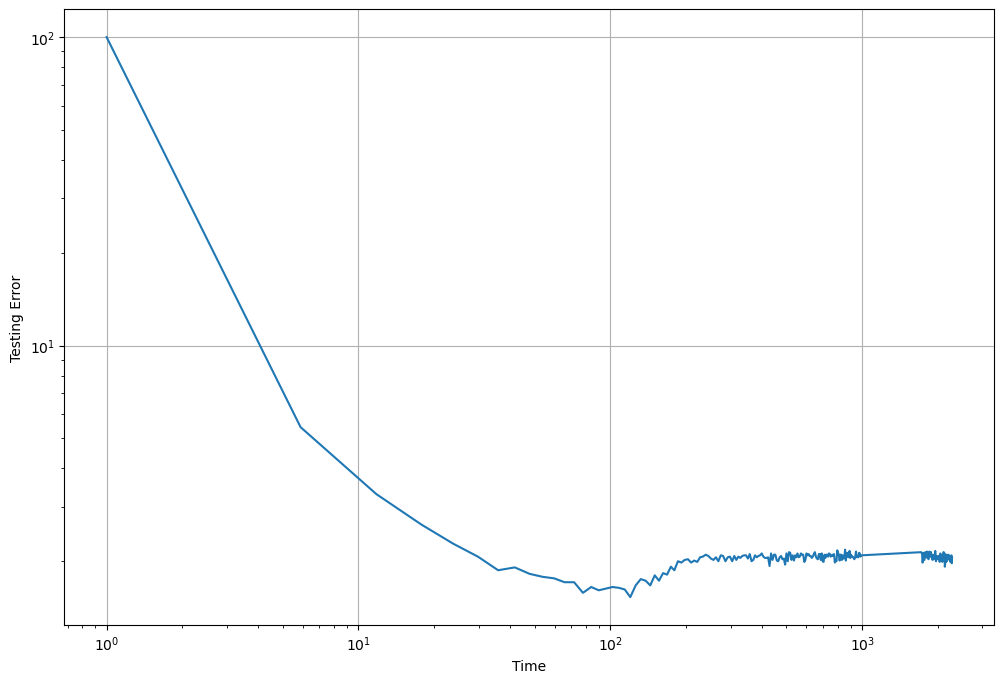

In [41]:
train_acc = []
val_acc = []
times = []
train_acc.append(100.0)
val_acc.append(100.0)
times.append(1.0)
for metrics in server.log["performance_metrics"]:
    train_acc.append(100-metrics["train_acc"]*100)
    val_acc.append(100-metrics["val_acc"]*100)
    times.append(metrics["time"])
plt.figure(figsize=(12,8))
plt.xscale("log")
plt.yscale("log")
plt.plot(times, val_acc)
plt.grid(visible=True)
plt.xlabel("Time")
plt.ylabel("Testing Error")
plt.savefig("Variational Inference on MNIST, lr=0.002.png")
plt.show()